# cdpi : Causal Discovery Python Implementation

## Constraint-based Algorithm_pc

### Note : PC Algorithm

#### Pseudo Code

**\[Assumption\]**


- No hidden confounder Assumption
- Markov Causal Assumption
- Faithfulness Assumption

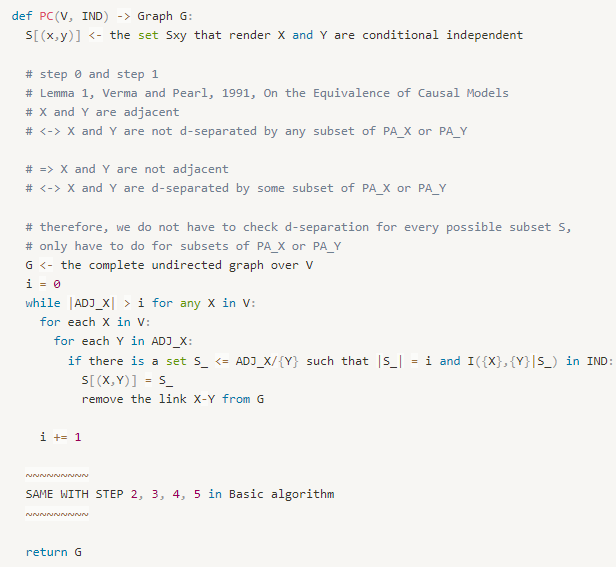 [3]

❗ The original code is C-style, so I modify the code to be similar to Python style


❓ What is 'Basic algorithm'? ⇒ See [Constraint-based Algorithm_basic](https://colab.research.google.com/drive/1Rrpdw1IlPNKN_yVqc1ZSFx_fzKfHdDtD?usp=sharing)

Even in the worst-case, PC algorithm has the same time complexity as Basic algorithm and it becomes reasonably efficient if the graph becomes sparse. [3]

#### Soundness & Completeness of PC algorithm

The result of step 0 & 1 in PC algorithm is same with the one of step 0 & 1 in Basic algorithm.[4] The other steps are equal with Basic algorithm. Therefore, the DAG pattern generated by PC algorithm is **sound** and **complete**.

### Implementation

We only need to change step 0 & 1.

#### STEP 0 & 1 : Find Skeleton by relation of adjacency and d-separation ( = p-independence in practice)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from itertools import combinations, chain
from collections import defaultdict

In [2]:
def identify_skeleton_from_full_link_graph(self, data, test_kwarg):
    self.ptn = pattern()
    self.ptn.add_vertex(list(data.columns))

    self.p_independence_set = defaultdict(set)
    self.p_independence_set = defaultdict(lambda: defaultdict(set))

    # Lemma 1, Verma and Pearl, 1991, On the Equivalence of Causal Models
    # X and Y are adjacent 
    # <-> X and Y are not d-separated by any subset of PA_X or PA_Y

    # => X and Y are not adjacent 
    # <-> X and Y are d-separated by some subset of PA_X or PA_Y

    # therefore, we do not have to check d-separation for every possible subset S, 
    # only have to do for subsets of PA_X or PA_Y

    self.ptn.full_link()

    adj = {x : self.ptn.adjacent(x) for x in self.ptn.vertex}
    
    i = 0
    while any(i < len(adj[x]) for x in adj.keys()):
        for x in self.ptn.vertex:
            adj_x = adj[x]

            for y in adj_x:
                adj_x_not_y = list(adj_x - {y})
                power_set = combinations(adj_x_not_y, i)
                for subset in power_set:
                    if self.test(data, {x}, {y}, set(subset), **test_kwarg):
                        self.p_independence_set[x][y]
                        self.p_independence_set[y][x] = self.p_independence_set[x][y]
                        self.p_independence_set[x][y].add(subset)

                        self.ptn.remove_links([(x, y)])
                        break
            
            adj[x] = self.ptn.adjacent(x)

        i += 1

#### class pc

In [3]:
pip install cdpi --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: cdpi
    Found existing installation: cdpi 0.0.9
    Uninstalling cdpi-0.0.9:
      Successfully uninstalled cdpi-0.0.9


In [4]:
from cdpi import pattern
from cdpi.causal_discovery.test import get_test
from cdpi.causal_discovery.util import (identify_skeleton_by_ind,
                                        identify_v_structure_with_adjacency_orient_faithfulness,
                                        identify_meeks_rule_2,
                                        identify_meeks_rule_3,
                                        identify_meeks_rule_4 )

In [5]:
class pc:
    def __init__(self):
        self.ptn = pattern()
    
    def identify(self, data:pd.DataFrame = None, test:str = None, ind:dict = None, vertex = None, **test_kwarg) -> pattern: 
        # STEP 0 ~ 1 : Find skeleton
        if ind is not None:
            self.identify_skeleton_by_ind(ind, vertex)
        elif data is not None and test is not None:
            self.test = get_test(test)
            self.identify_skeleton_from_full_link_graph(data, test_kwarg = test_kwarg)
        else:
            print("pc.identify : both ind and (data, test) are None!")


        # # STEP 2 : Find v-structure
        self.identify_v_structure_with_adjacency_orient_faithfulness()

        # STEP 3~5 : use Meek's rules
        cnt = True
        while cnt:
          cnt2 = self.identify_meeks_rule_2()
          cnt3 = self.identify_meeks_rule_3()
          cnt4 = self.identify_meeks_rule_4()

          cnt = cnt2 or cnt3 or cnt4 # Check there are vertexs which could be changed

        return self.ptn
    
    def draw(self):
        self.ptn.draw()

    def draw_by_pos(self, pos):
        self.ptn.draw_by_pos(pos)
        
pc.identify_skeleton_from_full_link_graph = identify_skeleton_from_full_link_graph
pc.identify_v_structure_with_adjacency_orient_faithfulness = identify_v_structure_with_adjacency_orient_faithfulness
pc.identify_meeks_rule_2 = identify_meeks_rule_2
pc.identify_meeks_rule_3 = identify_meeks_rule_3
pc.identify_meeks_rule_4 = identify_meeks_rule_4
pc.identify_skeleton_by_ind = identify_skeleton_by_ind

### Example

In [6]:
np.random.seed(seed=2022)

#### Discrete

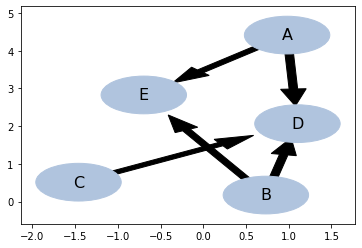

In [8]:
import scipy.stats as stats

size = 500

data = pd.DataFrame()
data['A'] =  stats.bernoulli(p = 0.5).rvs(size = size)
data['B'] =  stats.bernoulli(p = 0.5).rvs(size = size)
data['C'] =  stats.bernoulli(p = 0.5).rvs(size = size)
data['D'] =  data['A'] + data['B'] + data['C'] + stats.bernoulli(p = 0.5).rvs(size = size)
data['E'] =  data['A'] + data['B'] + stats.bernoulli(p = 0.5).rvs(size = size)

pc_al = pc()
pc_al.identify(data, test = 'conditional_mutual_information_test')
pc_al.draw()

#### For given IND

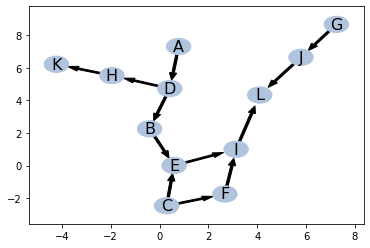

In [17]:
ptn = pattern()
ptn.add_edges([
    ('A', 'D'),
    ('D', 'B'),
    ('B', 'E'),
    ('C', 'E'),
    ('C', 'F'),
    ('D', 'H'),
    ('E', 'I'),
    ('F', 'I'),
    ('H', 'K'),
    ('I', 'L'),
    ('J', 'L'),
    ('G', 'J')])
ptn.draw()
pos = ptn.pos

In [18]:
ind = ptn.get_all_d_separation()

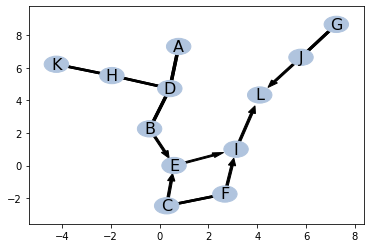

In [19]:
pc_al = pc()
pc_al.identify(ind = ind)
pc_al.draw_by_pos(pos)

### Reference

[3] Metropolitan. (2004). Learning Bayesian Networks. chapter 10. pp.546.


[4] Verma, T., Pearl, J. (1990). On the Equivalence of Causal Models. Appears in Proceedings of the Sixth Conference on Uncertainty in Artificial Intelligence (UAI1990).